In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [6]:
path = 'Data/Variants/Infected/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files['대구']

data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,16.0,4.16,0.32
1,2021-04-13,9.0,2.34,0.18
2,2021-04-14,11.0,2.86,0.22
3,2021-04-15,18.0,4.68,0.36
4,2021-04-16,4.0,1.04,0.08
...,...,...,...,...
121,2021-08-11,66.0,0.66,62.70
122,2021-08-12,39.0,0.39,37.05
123,2021-08-13,57.0,0.57,54.15
124,2021-08-14,82.0,0.82,77.90


In [7]:
dic_files

{'강원':          stdDay  incDec  alpha_variants  delta_variants
 0    2021-04-12     6.0            1.56            0.12
 1    2021-04-13    13.0            3.38            0.26
 2    2021-04-14     6.0            1.56            0.12
 3    2021-04-15    18.0            4.68            0.36
 4    2021-04-16     7.0            1.82            0.14
 ..          ...     ...             ...             ...
 121  2021-08-11    19.0            0.19           18.05
 122  2021-08-12    42.0            0.42           39.90
 123  2021-08-13    33.0            0.33           31.35
 124  2021-08-14    39.0            0.39           37.05
 125  2021-08-15    31.0            0.31           29.45
 
 [126 rows x 4 columns],
 '경기':          stdDay  incDec  alpha_variants  delta_variants
 0    2021-04-12     176           45.76            3.52
 1    2021-04-13     168           43.68            3.36
 2    2021-04-14     238           61.88            4.76
 3    2021-04-15     224           58.24         

In [8]:
learning_rates_list = [1e-3, 1e-4, 1e-5]
patiences_list = [20, 50]
num_layers_list = [1, 2, 4, 8]
batch_sizes_list = [32, 64]
hidden_sizes_list = [8, 16, 32]
dropout_list = [0.25]

hyperparameter_dict = {}
i = 0

for lr in learning_rates_list:
    for patience in patiences_list:
        for num_layers in num_layers_list:
            for batch_sizes in batch_sizes_list:
                for hidden_size in hidden_sizes_list:    
                    for dropout in dropout_list:
                        hyperparameter_dict[i] = [lr, patience, num_layers, batch_sizes, hidden_size, dropout]
                        i += 1
                        
print(i)

144


In [9]:
criterion = nn.MSELoss()

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'stdDay', 'alpha_variants')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

rmse_min = np.inf
best_model = {}

for hyperparameter in tqdm(hyperparameter_dict.values(), desc = '대구_RNN', position = 0):
    lr = hyperparameter[0]
    patience = hyperparameter[1]
    num_layers = hyperparameter[2]
    batch_size = hyperparameter[3]
    hidden_size = hyperparameter[4]
    dropout = hyperparameter[5]
    print('-------------------------------------------------------------------------------------')
    print('lr:', lr, ' patience:', patience, ' num_layers:', num_layers, 
          ' batch_size:', batch_size, ' hidden_size:', hidden_size, ' dropout:', dropout)
    
    x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 59, 60, 1, batch_size, 'mto')
    

    model = RNN(input_size = input_size,
                hidden_size = hidden_size,
                sequence_length = sequence_length,
                num_layers = num_layers, 
                dropout = dropout, 
                device = device).to(device)

    optimizer = Adam(model.parameters(), lr = lr)
    
    loss_list, model, epoch = Trainer.Many_to_One(train_loader, 
                                                  test_loader, 
                                                  model, 
                                                  criterion, 
                                                  optimizer, 
                                                  num_epochs, 
                                                  patience,
                                                  device)
    
    label_y, predicted = predict_mto(model, df, x_ss, y_ms)
    
    if rmse_min > rmse(label_y[-7:], predicted[-7:]):
        rmse_min = rmse(label_y[-7:], predicted[-7:])
        best_model['RNN'] = [rmse_min, model, loss_list, epoch, lr, patience, 
                             num_layers, batch_size, hidden_size, dropout]

대구_RNN:   0%|          | 0/144 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


KeyboardInterrupt: 

In [13]:
model

RNN(
  (rnn): RNN(3, 32, batch_first=True, dropout=0.25)
  (fc1): Linear(in_features=1920, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [10]:
best_model

{'RNN': [0.33072477122512367,
  RNN(
    (rnn): RNN(3, 8, batch_first=True, dropout=0.25)
    (fc1): Linear(in_features=480, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU()
  ),
  [0.00866688194219023,
   0.006810140504967421,
   0.002875328646041453,
   0.002544267103075981,
   0.0010160062811337411,
   0.0014434223994612694,
   0.0013273090589791536,
   0.0007012908754404634,
   0.0007887618849053979,
   0.0007164482085499913,
   0.0003798442776314914,
   0.0003963094059145078,
   0.00041446296381764114,
   0.00022068404359743,
   0.0002282380846736487,
   0.00023273922124644741,
   0.0001377280059386976,
   0.00014625212861574255,
   0.00015362208796432242,
   0.00010337016283301637,
   0.00010811726679094136,
   9.512742508377414e-05,
   6.474506972153904e-05,
   7.325800652324688e-05,
   6.255566404433921e-05,
   5.0554201607155846e-05,
   5.4468171583721414e

In [6]:
save_model(best_model['RNN'][1].state_dict(), "model/Infected/alpha/RNN.pth")
save_hyperparameter(best_model['RNN'][3:], "hyperparameter/Infected/alpha/RNN.pkl")

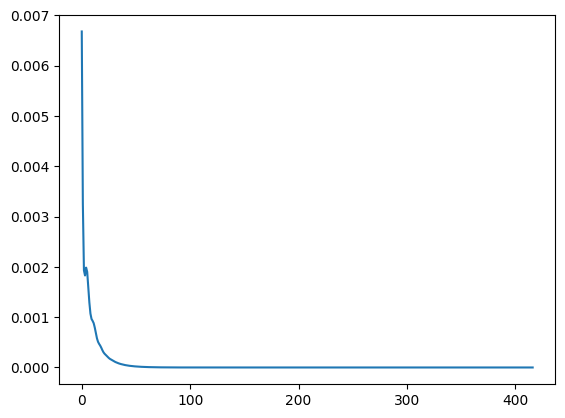

In [7]:
plt.plot(best_model['RNN'][2])

In [8]:
label_y, predicted = predict_mto(best_model['RNN'][1], df, x_ss, y_ms)

0.07202486256580852


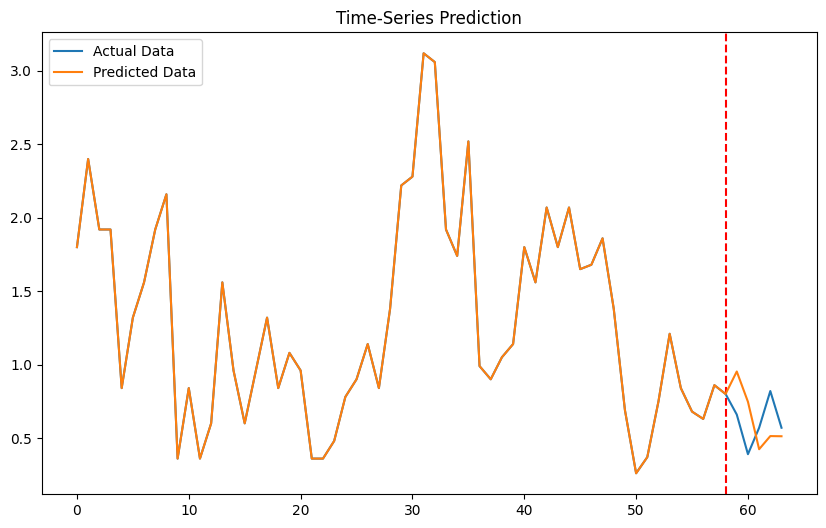

In [9]:
print(rmse(label_y[-7:], predicted[-7:]))
plotting(label_y, predicted, 58)